In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
import seaborn as sns
from sklearn.decomposition import PCA
from ast import literal_eval
from collections import Counter
import gower

In [2]:
user_profile = pd.read_csv("data/user_profile/prepared/User_Profile_for_Voice_Analysis.csv")

In [3]:
user_profile.drop(["Unnamed: 0"],axis=1, inplace=True)

## Scaling Categorical Features

In [4]:
data = user_profile.iloc[:,[4,7,10,13,16,20,26,28,62,18,23,24,29,30,38,41,45,49,53,64,75,76,77,78,79,80,81,82,83]]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ONNET_OUTGOING_Scaled                 3000 non-null   float64
 1   ONNET_INCOMING_Scaled                 2890 non-null   float64
 2   OFFNET_OUTGOING_Scaled                2886 non-null   float64
 3   OFFNET_INCOMING_Scaled                2942 non-null   float64
 4   IDD_INCOMING_Scaled                   1491 non-null   float64
 5   IDD_OUTGOING_Scaled                   484 non-null    float64
 6   PEO_TV_Scaled                         1135 non-null   float64
 7   BB_Scaled                             1112 non-null   float64
 8   BB_Extra_GB_Purchased_Scaled          366 non-null    float64
 9   IDD_incoming_country                  1491 non-null   object 
 10  IDD_outgoing_country                  484 non-null    object 
 11  Peo_TV_Package   

### Filling null values 

#### Filling Usage Columns - with MEAN for particular Sub Type based Usage, else 0

In [5]:
data["Sub_Type"].value_counts()

TRIPLE_PLAY       2412
DOUBLE_PLAY_BV     263
SINGLE_PLAY        198
DOUBLE_PLAY_PV     126
4G                   1
Name: Sub_Type, dtype: int64

In [6]:
usage_cols = ["ONNET_OUTGOING_Scaled","ONNET_INCOMING_Scaled","OFFNET_OUTGOING_Scaled","OFFNET_INCOMING_Scaled","OFFNET_INCOMING_Scaled"]

In [7]:
for col in usage_cols:
    data[col] = np.where(data["Sub_Type"].isnull() == False & data[col].isnull(), data[col].fillna(data[col].mean()), data[col])

<ipython-input-7-cdc94c9275ff>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-cdc94c9275ff>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-cdc94c9275ff>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-cdc94c9275f

In [8]:
data["ONNET_OUTGOING_Scaled"].value_counts()

0.001202    57
0.001570    32
0.002772    25
0.002404    24
0.005544    16
            ..
0.088525     1
0.031667     1
0.020114     1
0.008095     1
0.044643     1
Name: ONNET_OUTGOING_Scaled, Length: 2278, dtype: int64

In [9]:
data["PEO_TV_Scaled"] = np.where(data["PEO_TV_Scaled"].isnull() & ((data["Sub_Type"]=="DOUBLE_PLAY_PV") | (data["Sub_Type"]=="TRIPLE_PLAY")), data["PEO_TV_Scaled"].fillna(data["PEO_TV_Scaled"].mean()), data["PEO_TV_Scaled"])

<ipython-input-9-4777164b7e7f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
data["PEO_TV_Scaled"].value_counts()

0.564433    1569
0.000000     195
0.950000     157
0.712500      70
0.918750      51
            ... 
0.281250       1
0.468750       1
0.462500       1
0.375000       1
0.456250       1
Name: PEO_TV_Scaled, Length: 129, dtype: int64

In [11]:
data["BB_Scaled"] = np.where(data["BB_Scaled"].isnull() & ((data["Sub_Type"]=="DOUBLE_PLAY_BV") | (data["Sub_Type"]=="TRIPLE_PLAY")), data["BB_Scaled"].fillna(data["BB_Scaled"].mean()), data["BB_Scaled"])

<ipython-input-11-e8be941d476f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
data["BB_Scaled"].value_counts()

0.364073    1564
0.064236      16
0.072917      12
0.916667      11
0.197917      10
            ... 
0.809028       1
0.371528       1
0.472222       1
0.470486       1
0.444444       1
Name: BB_Scaled, Length: 359, dtype: int64

In [13]:
data[["PEO_TV_Scaled","BB_Scaled","BB_Extra_GB_Purchased_Scaled","IDD_INCOMING_Scaled","IDD_OUTGOING_Scaled"]] = data[["PEO_TV_Scaled","BB_Scaled","BB_Extra_GB_Purchased_Scaled","IDD_INCOMING_Scaled","IDD_OUTGOING_Scaled"]].fillna(0)

/home/chiran/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
data[["IDD_incoming_country","IDD_outgoing_country","Peo_TV_Package","Voice_VAS_Package","BB_VAS_Package","Peo_VAS_Package","Other_VAS_Package","Having_Insurance","Tamil_Customer"]] = data[["IDD_incoming_country","IDD_outgoing_country","Peo_TV_Package","Voice_VAS_Package","BB_VAS_Package","Peo_VAS_Package","Other_VAS_Package","Having_Insurance","Tamil_Customer"]].fillna("NO")

In [15]:
data.isnull().sum()

ONNET_OUTGOING_Scaled                     0
ONNET_INCOMING_Scaled                     0
OFFNET_OUTGOING_Scaled                    0
OFFNET_INCOMING_Scaled                    0
IDD_INCOMING_Scaled                       0
IDD_OUTGOING_Scaled                       0
PEO_TV_Scaled                             0
BB_Scaled                                 0
BB_Extra_GB_Purchased_Scaled              0
IDD_incoming_country                      0
IDD_outgoing_country                      0
Peo_TV_Package                            0
Location_Identifier                       0
GENDER                                  792
Sub_Type                                  0
Voice_VAS_Package                         0
BB_VAS_Package                            0
Peo_VAS_Package                           0
Other_VAS_Package                         0
Having_Insurance                          0
Tamil_Customer                            0
Peo_Packages_if_Senior_Citizen            0
Peo_Packages_if_Kids            

In [16]:
#data_cat = data.iloc[:,9:25]

In [17]:
data.describe()

ONNET_OUTGOING_Scaled  ONNET_INCOMING_Scaled  OFFNET_OUTGOING_Scaled  \
count            3000.000000            3000.000000             3000.000000   
mean                0.100546               0.102755                0.112042   
std                 0.102593               0.102851                0.112760   
min                 0.001202               0.001202                0.001202   
25%                 0.020598               0.022107                0.029214   
50%                 0.065260               0.073489                0.083252   
75%                 0.156900               0.152129                0.153552   
max                 1.000000               1.000000                1.000000   

       OFFNET_INCOMING_Scaled  IDD_INCOMING_Scaled  IDD_OUTGOING_Scaled  \
count             3000.000000          3000.000000          3000.000000   
mean                 0.110629             0.045441             0.015381   
std                  0.097198             0.122852             0.067816   
min                  0.001202             0.000000             0.000000   
25%                  0.031389             0.000000             0.000000   
50%                  0.092425             0.000000             0.000000   
75%                  0.162155             0.020000             0.000000   
max                  0.948718             0.882000             0.833333   

       PEO_TV_Scaled    BB_Scaled  BB_Extra_GB_Purchased_Scaled  \
count    3000.000000  3000.000000                   3000.000000   
mean        0.508742     0.324753                      0.019187   
std         0.266024     0.194438                      0.094044   
min         0.000000     0.000000                      0.000000   
25%         0.564433     0.220486                      0.000000   
50%         0.564433     0.364073                      0.000000   
75%         0.564433     0.364073                      0.000000   
max         0.975000     1.000000                      0.982759   

       Peo_Packages_if_Senior_Citizen  Peo_Packages_if_Kids  \
count                     3000.000000           3000.000000   
mean                         0.002067              0.000533   
std                          0.020229              0.010316   
min                          0.000000              0.000000   
25%                          0.000000              0.000000   
50%                          0.000000              0.000000   
75%                          0.000000              0.000000   
max                          0.200000              0.200000   

       Peo_Packages_if_Teenager_Students  \
count                        3000.000000   
mean                            0.001400   
std                             0.016677   
min                             0.000000   
25%                             0.000000   
50%                             0.000000   
75%                             0.000000   
max                             0.200000   

       Peo_Package_if_Working_Professionals  VAS_if_Kids  \
count                           3000.000000  3000.000000   
mean                               0.003333     0.013567   
std                                0.025608     0.094422   
min                                0.000000     0.000000   
25%                                0.000000     0.000000   
50%                                0.000000     0.000000   
75%                                0.000000     0.000000   
max                                0.200000     1.000000   

       VAS_if_Teenager_Students  VAS_if_Working_Professionals  \
count               3000.000000                   3000.000000   
mean                   0.049267                      0.042733   
std                    0.128342                      0.107932   
min                    0.000000                      0.000000   
25%                    0.000000                      0.000000   
50%                    0.000000                      0.000000   
75%                    0.000000                      0

### Correlations

In [18]:
data.corr()

ONNET_OUTGOING_Scaled  \
ONNET_OUTGOING_Scaled                              1.000000   
ONNET_INCOMING_Scaled                              0.772425   
OFFNET_OUTGOING_Scaled                             0.574739   
OFFNET_INCOMING_Scaled                             0.478098   
IDD_INCOMING_Scaled                                0.170245   
IDD_OUTGOING_Scaled                                0.102692   
PEO_TV_Scaled                                      0.022921   
BB_Scaled                                          0.070593   
BB_Extra_GB_Purchased_Scaled                       0.223187   
Peo_Packages_if_Senior_Citizen                    -0.003214   
Peo_Packages_if_Kids                              -0.027599   
Peo_Packages_if_Teenager_Students                 -0.021206   
Peo_Package_if_Working_Professionals               0.002099   
VAS_if_Kids                                        0.165276   
VAS_if_Teenager_Students                           0.126893   
VAS_if_Working_Professionals                       0.105148   
IDD_if_Family_Member_Abroad                        0.088368   

                                      ONNET_INCOMING_Scaled  \
ONNET_OUTGOING_Scaled                              0.772425   
ONNET_INCOMING_Scaled                              1.000000   
OFFNET_OUTGOING_Scaled                             0.503179   
OFFNET_INCOMING_Scaled                             0.636554   
IDD_INCOMING_Scaled                                0.191909   
IDD_OUTGOING_Scaled                                0.069736   
PEO_TV_Scaled                                      0.003926   
BB_Scaled                                          0.039502   
BB_Extra_GB_Purchased_Scaled                       0.199010   
Peo_Packages_if_Senior_Citizen                     0.007574   
Peo_Packages_if_Kids                              -0.024630   
Peo_Packages_if_Teenager_Students                 -0.024299   
Peo_Package_if_Working_Professionals               0.014408   
VAS_if_Kids                                        0.176010   
VAS_if_Teenager_Students                           0.099176   
VAS_if_Working_Professionals                       0.070118   
IDD_if_Family_Member_Abroad                        0.091361   

                                      OFFNET_OUTGOING_Scaled  \
ONNET_OUTGOING_Scaled                               0.574739   
ONNET_INCOMING_Scaled                               0.503179   
OFFNET_OUTGOING_Scaled                              1.000000   
OFFNET_INCOMING_Scaled                              0.652060   
IDD_INCOMING_Scaled                                 0.060279   
IDD_OUTGOING_Scaled                                 0.038531   
PEO_TV_Scaled                                      -0.017263   
BB_Scaled                                           0.024907   
BB_Extra_GB_Purchased_Scaled                        0.204439   
Peo_Packages_if_Senior_Citizen                     -0.020001   
Peo_Packages_if_Kids                               -0.028491   
Peo_Packages_if_Teenager_Students                  -0.020526   
Peo_Package_if_Working_Professionals                0.001688   
VAS_if_Kids                                         0.097865   
VAS_if_Teenager_Students                            0.123779   
VAS_if_Working_Professionals                        0.100444   
IDD_if_Family_Member_Abroad                         0.031514   

                                      OFFNET_INCOMING_Scaled  \
ONNET_OUTGOING_Scaled                               0.478098   
ONNET_INCOMING_Scaled                               0.636554   
OFFNET_OUTGOING_Scaled                              0.652060   
OFFNET_INCOMING_Scaled                              1.000000   
IDD_INCOMING_Scaled                                 0.184436   
IDD_OUTGOING_Scaled                                 0.055937   
PEO_TV_Scaled                                       0.004364   
BB_Scaled                                           0.035092   
BB_Extra_GB_Purchased_Scaled           

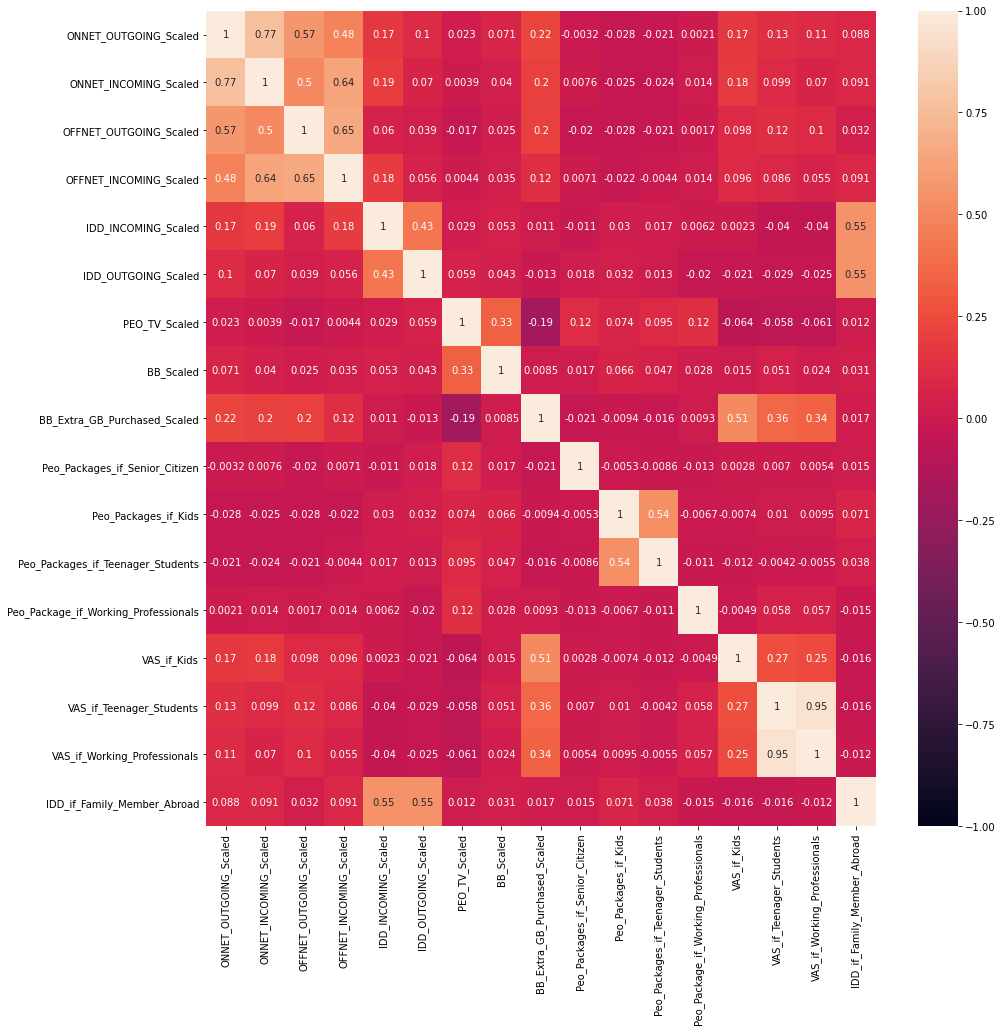

In [19]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),annot=True,vmin=-1,vmax=1)
plt.show()

In [20]:
x=data.values

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ONNET_OUTGOING_Scaled                 3000 non-null   float64
 1   ONNET_INCOMING_Scaled                 3000 non-null   float64
 2   OFFNET_OUTGOING_Scaled                3000 non-null   float64
 3   OFFNET_INCOMING_Scaled                3000 non-null   float64
 4   IDD_INCOMING_Scaled                   3000 non-null   float64
 5   IDD_OUTGOING_Scaled                   3000 non-null   float64
 6   PEO_TV_Scaled                         3000 non-null   float64
 7   BB_Scaled                             3000 non-null   float64
 8   BB_Extra_GB_Purchased_Scaled          3000 non-null   float64
 9   IDD_incoming_country                  3000 non-null   object 
 10  IDD_outgoing_country                  3000 non-null   object 
 11  Peo_TV_Package   

## Measuring Distances of Categorical Variables with Gower 

In [22]:
cat_f = [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False]
len(cat_f)

29

In [23]:
dm = gower.gower_matrix(data, cat_features = cat_f )

# Applying PCA

### Find most approporiate no of components

In [24]:
pc=PCA(n_components=29) # 23
pc.fit(dm)

PCA(n_components=29)

In [25]:
#How much variance,caputured individually
pc.explained_variance_

array([8.50288296e+00, 1.66606057e+00, 6.30969286e-01, 4.80004042e-01,
       3.38916659e-01, 2.68311799e-01, 1.82352751e-01, 1.17734261e-01,
       8.28171447e-02, 7.11521283e-02, 7.00665638e-02, 5.51188067e-02,
       3.94979492e-02, 3.55027989e-02, 3.22591290e-02, 2.64040064e-02,
       2.43715141e-02, 1.90629084e-02, 1.80335473e-02, 1.64408293e-02,
       1.39304372e-02, 1.17860520e-02, 1.09269135e-02, 9.70566738e-03,
       9.07649472e-03, 8.34029447e-03, 7.88200088e-03, 6.76263543e-03,
       6.31280430e-03], dtype=float32)

In [26]:
#How mucb variance, captured together
pc.explained_variance_ratio_.cumsum() 

array([0.6614515 , 0.79105675, 0.84014076, 0.877481  , 0.9038458 ,
       0.92471814, 0.9389036 , 0.94806236, 0.95450485, 0.96003985,
       0.96549046, 0.96977824, 0.97285086, 0.9756127 , 0.9781222 ,
       0.98017615, 0.98207206, 0.98355496, 0.9849578 , 0.98623675,
       0.9873204 , 0.98823726, 0.9890873 , 0.9898423 , 0.9905484 ,
       0.99119717, 0.9918103 , 0.9923364 , 0.9928275 ], dtype=float32)

/home/chiran/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



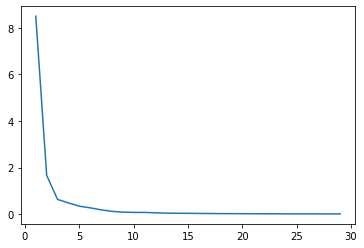

In [27]:
sns.lineplot(range(1,1+pc.explained_variance_.shape[0]),pc.explained_variance_)
plt.show()

In [28]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
pca_2d = PCA(n_components=2)
pca_2d.fit(dm)
reduced_data = pca_2d.fit_transform(dm)
results_2d_df = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

# applying min-max-scaler to reduced features
scaler = MinMaxScaler()
results_2d_df[['pca1','pca2']] = scaler.fit_transform(results_2d_df[['pca1','pca2']])

results = results_2d_df.values

In [29]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
pca_3d = PCA(n_components=3)
pca_3d.fit(dm)
reduced_data = pca_3d.fit_transform(dm)
results_3d_df = pd.DataFrame(reduced_data,columns=['pca1','pca2','pca3'])

# applying min-max-scaler to reduced features
scaler = MinMaxScaler()
results_3d_df[['pca1','pca2','pca3']] = scaler.fit_transform(results_3d_df[['pca1','pca2','pca3']])

results_3d = results_3d_df.values

# Clustering

## Hierarchical f Clusters and Dendrogram
- Hierarchical Clustering

In [30]:
result = linkage(dm, method="ward") 

In [31]:
ag_y_clusters = fcluster(result, 3, criterion='maxclust')
ag_y_clusters

array([2, 3, 2, ..., 1, 1, 2], dtype=int32)

In [32]:
len(ag_y_clusters)

3000

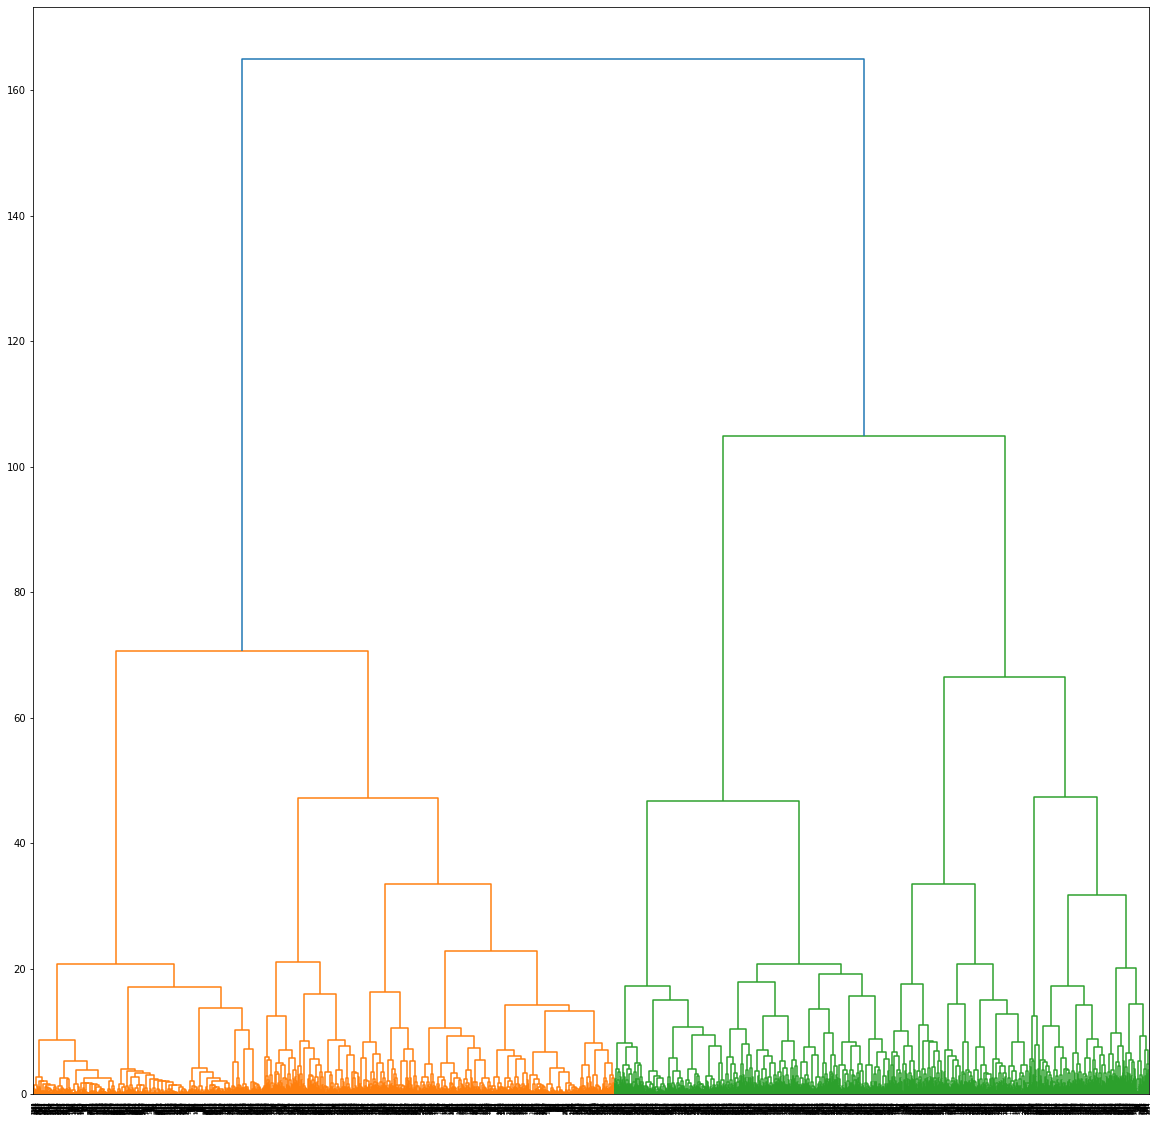

In [33]:
plt.figure(figsize=(20,20))
shc.dendrogram(result)
plt.show()

### Cluster counts: Fclusters

In [34]:
cluster_labels=["x",0,2,1]
val_dict = dict(zip(cluster_labels,np.bincount(ag_y_clusters)))
val_dict.pop("x")
val_dict

{0: 1562, 2: 742, 1: 696}

# Agglomerative Clustering - 3 Clusters

In [35]:
acl=AgglomerativeClustering(n_clusters=3,affinity="euclidean",linkage="ward")

In [36]:
acl.fit(dm)

AgglomerativeClustering(n_clusters=3)

In [37]:
# cluster labels
acl_y_clusters = acl.labels_

In [38]:
acl_y_clusters

array([2, 1, 2, ..., 0, 0, 2])

### Cluster counts: Ag Clusters

In [39]:
cluster_labels=[0,1,2]
dict(zip(cluster_labels,np.bincount(acl_y_clusters)))

{0: 1562, 1: 696, 2: 742}

# Agglomerative Clustering - 4 Clusters

In [40]:
acl=AgglomerativeClustering(n_clusters=4,affinity="euclidean",linkage="ward")

In [41]:
acl.fit(dm)

AgglomerativeClustering(n_clusters=4)

In [42]:
# cluster labels
acl_4_y_clusters = acl.labels_

In [43]:
acl_4_y_clusters

array([2, 0, 2, ..., 3, 3, 2])

### Cluster counts: Ag Clusters

In [44]:
cluster_labels=[0,1,2,3]
dict(zip(cluster_labels,np.bincount(acl_4_y_clusters)))

{0: 696, 1: 946, 2: 742, 3: 616}

# K-Means Clustering

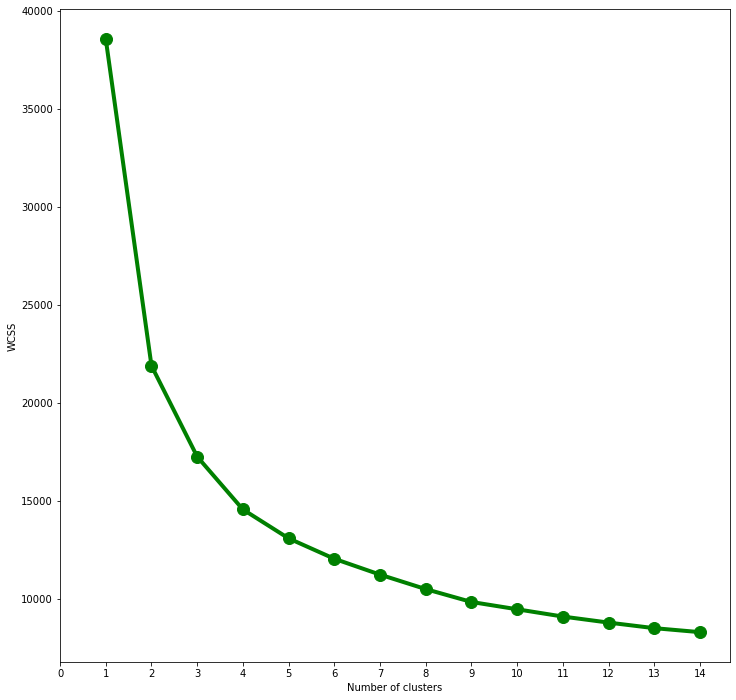

In [45]:
# find the optimal number of clusters using elbow method
WCSS = []
for i in range(1,15):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(dm)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (12,12))
plt.plot(range(1,15),WCSS, linewidth=4, markersize=12,marker='o',color = 'green')
plt.xticks(np.arange(15))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [46]:
# since elbow occured at 3, let's consider 3 clusters
km_model = KMeans(n_clusters = 3, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
kmeans_y_clusters = km_model.fit_predict(dm)

In [47]:
kmeans_y_clusters

array([0, 0, 0, ..., 1, 1, 0], dtype=int32)

In [48]:
km_model.labels_

array([0, 0, 0, ..., 1, 1, 0], dtype=int32)

In [49]:
cluster_labels=[0,1,2]
dict(zip(cluster_labels,np.bincount(km_model.labels_)))

{0: 1254, 1: 1224, 2: 522}

In [50]:
km_model.cluster_centers_

array([[0.23617971, 0.27939242, 0.28718615, ..., 0.21305245, 0.19521528,
        0.26538625],
       [0.1898901 , 0.21515234, 0.23397481, ..., 0.13410568, 0.10789362,
        0.21045338],
       [0.32395795, 0.34310353, 0.3580471 , ..., 0.30247766, 0.2930369 ,
        0.33739296]], dtype=float32)

### 2D visualizations

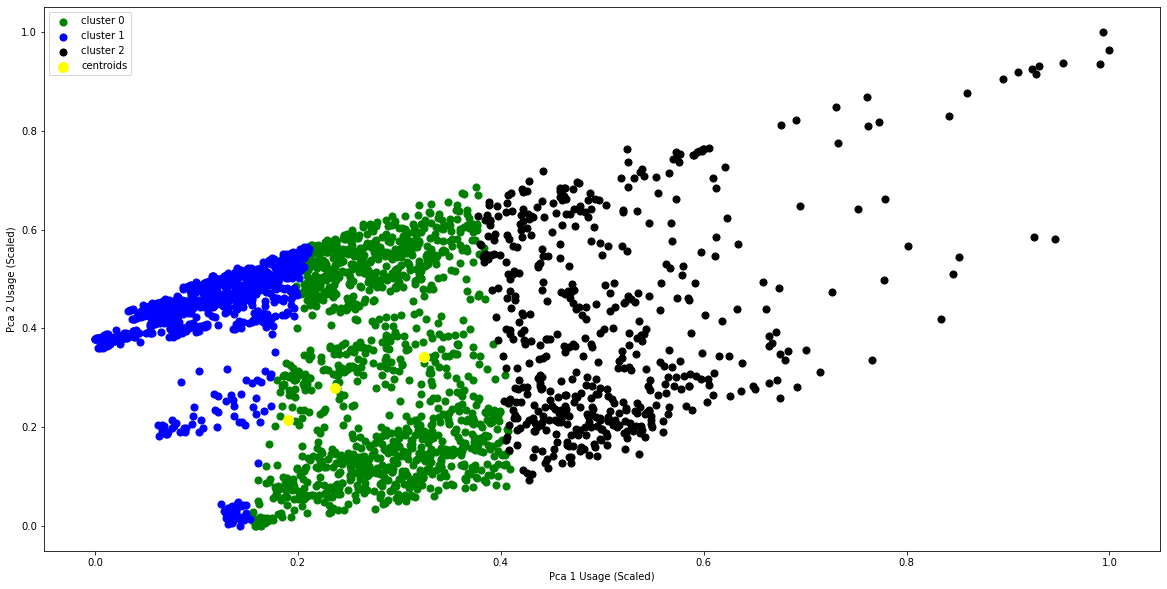

In [51]:
plt.figure(figsize = (20,10))
plt.scatter(results[kmeans_y_clusters == 0,0],results[kmeans_y_clusters == 0,1],s = 50, c = 'green', label = "cluster 0")
plt.scatter(results[kmeans_y_clusters == 1,0],results[kmeans_y_clusters == 1,1],s = 50, c = 'blue', label = "cluster 1")
plt.scatter(results[kmeans_y_clusters == 2,0],results[kmeans_y_clusters == 2,1],s = 50, c = 'black', label = "cluster 2")
#plt.scatter(results[y_clusters == 3,0],results[y_clusters == 3,1],s = 50, c = 'red', label = "cluster 3")
plt.scatter(km_model.cluster_centers_[:,0],km_model.cluster_centers_[:,1], s = 100, c = "yellow", label = "centroids")
plt.xlabel("Pca 1 Usage (Scaled)")
plt.ylabel("Pca 2 Usage (Scaled)")
plt.legend()
plt.show()

### 3D Visualizations

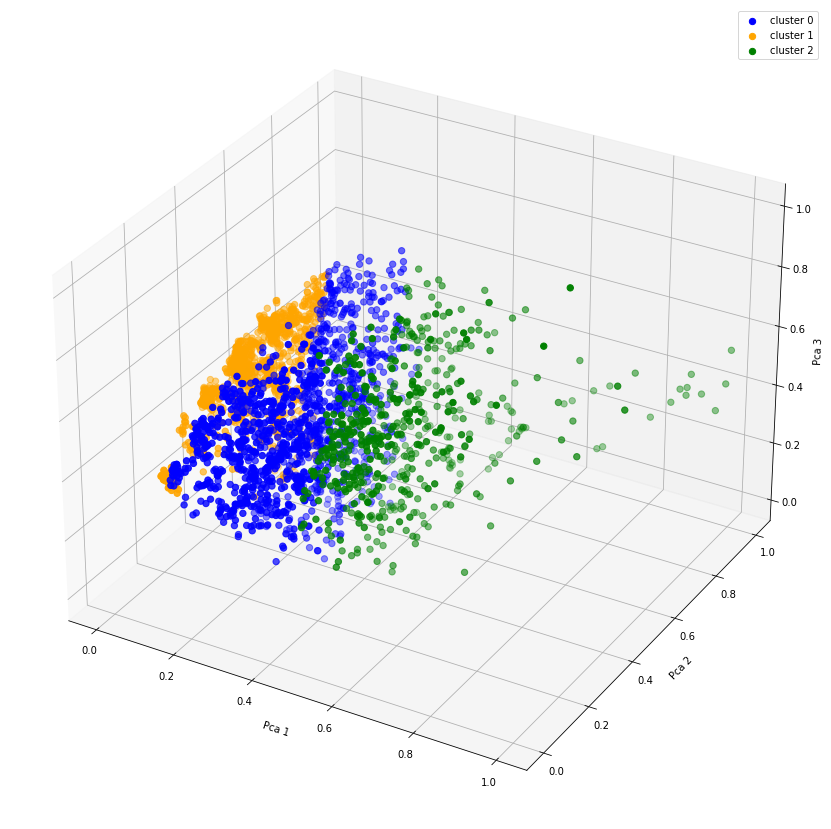

In [52]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results_3d[kmeans_y_clusters == 0,0],results_3d[kmeans_y_clusters == 0,1],results_3d[kmeans_y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(results_3d[kmeans_y_clusters == 1,0],results_3d[kmeans_y_clusters == 1,1],results_3d[kmeans_y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(results_3d[kmeans_y_clusters == 2,0],results_3d[kmeans_y_clusters == 2,1],results_3d[kmeans_y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
#ax.scatter(results_3d[y_clusters == 3,0],results_3d[y_clusters == 3,1],results_3d[y_clusters == 3,2], s = 40 , color = 'red', label = "cluster 2")
ax.set_xlabel('Pca 1')
ax.set_ylabel('Pca 2')
ax.set_zlabel('Pca 3')
ax.legend()
plt.show()

In [53]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'Pca 1'),yaxis = dict(title  = 'Pca 2'),zaxis = dict(title  = 'Pca 3'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = km_model.labels_
trace = go.Scatter3d(x=results_3d[:, 0], y=results_3d[:, 1], z=results_3d[:, 2], mode='markers',marker=dict(color = labels, size= 5, line=dict(color= 'black',width =1)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

# K-Medoids Clustering

In [54]:
#Reference : https://stackoverflow.com/questions/66441887/how-can-i-implement-pam-clustering-algorithm-using-gower-distance-in-sklearn
#https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html
kmedoids = KMedoids(n_clusters=3, random_state=0,metric = 'precomputed', method = 'pam', init =  'k-medoids++')

In [55]:
#kmedoids.fit(dm)

In [56]:
kmod_y_clusters = kmedoids.fit_predict(dm)

In [57]:
kmod_y_clusters

array([2, 2, 2, ..., 2, 2, 2])

In [58]:
kmedoids.labels_

array([2, 2, 2, ..., 2, 2, 2])

In [59]:
print(kmedoids.cluster_centers_)

None


In [60]:
cluster_labels=[0,1,2]
dict(zip(cluster_labels,np.bincount(kmedoids.labels_)))

{0: 423, 1: 897, 2: 1680}

### 2D visualizations

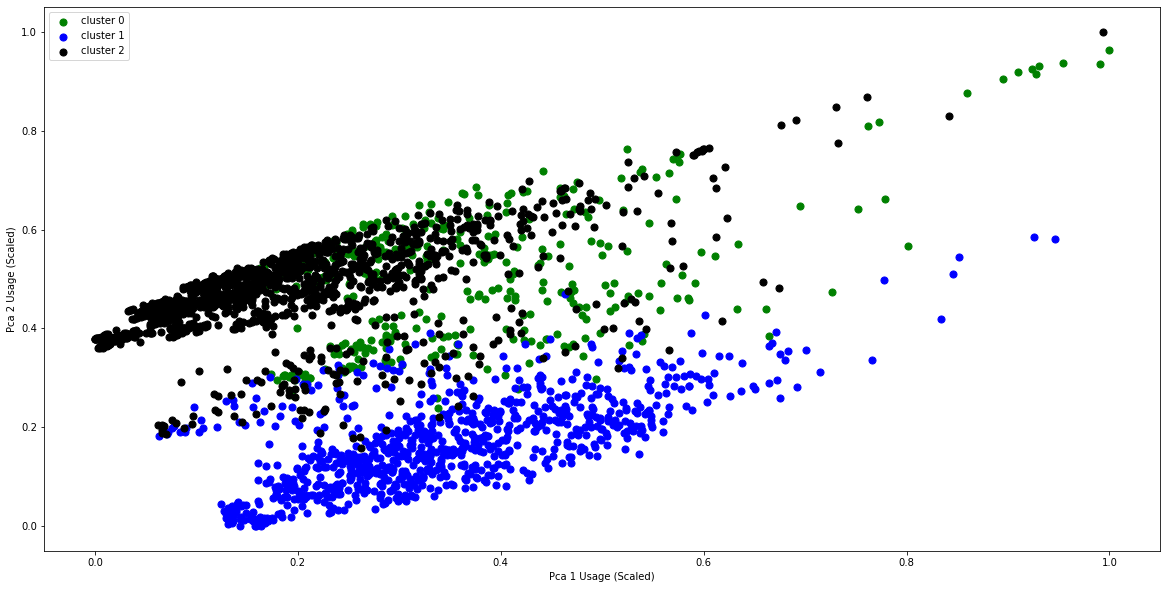

In [61]:
plt.figure(figsize = (20,10))
plt.scatter(results[kmod_y_clusters == 0,0],results[kmod_y_clusters == 0,1],s = 50, c = 'green', label = "cluster 0")
plt.scatter(results[kmod_y_clusters == 1,0],results[kmod_y_clusters == 1,1],s = 50, c = 'blue', label = "cluster 1")
plt.scatter(results[kmod_y_clusters == 2,0],results[kmod_y_clusters == 2,1],s = 50, c = 'black', label = "cluster 2")
#plt.scatter(results[y_clusters == 3,0],results[y_clusters == 3,1],s = 50, c = 'red', label = "cluster 3")
#plt.scatter(kmedoids.cluster_centers_[:,0],kmedoids.cluster_centers_[:,1], s = 100, c = "yellow", label = "centroids")
plt.xlabel("Pca 1 Usage (Scaled)")
plt.ylabel("Pca 2 Usage (Scaled)")
plt.legend()
plt.show()

### 3D Visualizations

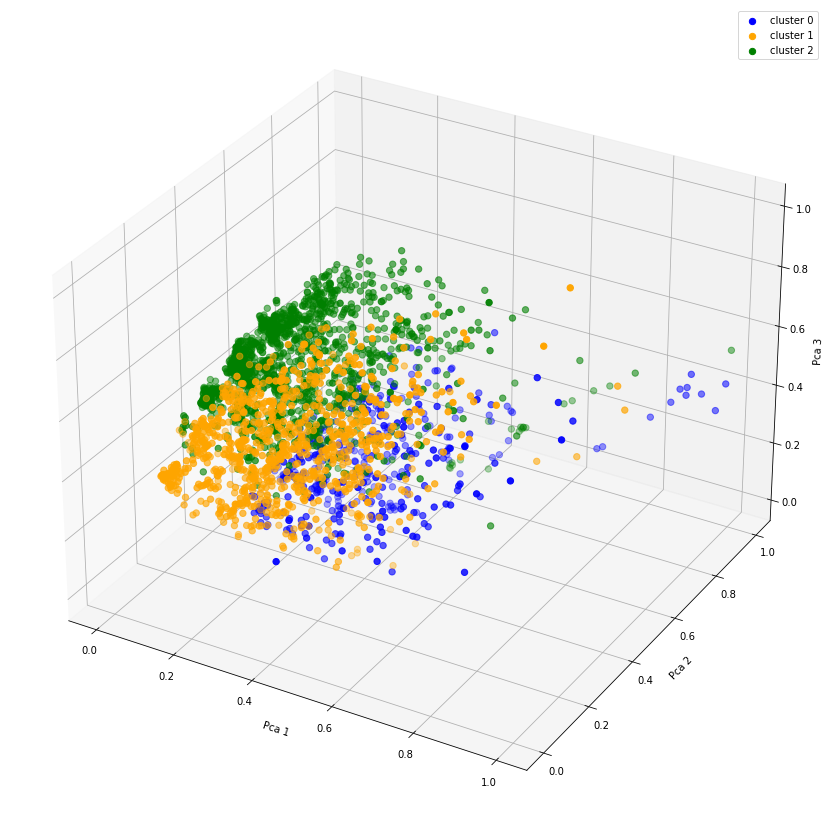

In [62]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results_3d[kmod_y_clusters == 0,0],results_3d[kmod_y_clusters == 0,1],results_3d[kmod_y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(results_3d[kmod_y_clusters == 1,0],results_3d[kmod_y_clusters == 1,1],results_3d[kmod_y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(results_3d[kmod_y_clusters == 2,0],results_3d[kmod_y_clusters == 2,1],results_3d[kmod_y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
#ax.scatter(results_3d[y_clusters == 3,0],results_3d[y_clusters == 3,1],results_3d[y_clusters == 3,2], s = 40 , color = 'red', label = "cluster 2")
ax.set_xlabel('Pca 1')
ax.set_ylabel('Pca 2')
ax.set_zlabel('Pca 3')
ax.legend()
plt.show()

In [63]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'Pca 1'),yaxis = dict(title  = 'Pca 2'),zaxis = dict(title  = 'Pca 3'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = kmedoids.labels_
trace = go.Scatter3d(x=results_3d[:, 0], y=results_3d[:, 1], z=results_3d[:, 2], mode='markers',marker=dict(color = labels, size= 5, line=dict(color= 'black',width =1)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

## Adding clusters column to existing user profile

In [64]:
user_profile["KMOD_3_Cluster"] = kmod_y_clusters

In [65]:
user_profile["H_3_Cluster"] = acl_y_clusters

In [66]:
user_profile["H_4_Cluster"] = acl_4_y_clusters

In [67]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 87 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   event_source.hash                     3000 non-null   object 
 1   ACCOUNT_NUM.hash                      3000 non-null   object 
 2   CUSTOMER_REF.hash                     3000 non-null   object 
 3   ONNET_OUTGOING_Categorical            3000 non-null   object 
 4   ONNET_OUTGOING_Scaled                 3000 non-null   float64
 5   ONNET_OUTGOING_Outlier                3000 non-null   object 
 6   ONNET_INCOMING_Categorical            2890 non-null   object 
 7   ONNET_INCOMING_Scaled                 2890 non-null   float64
 8   ONNET_INCOMING_Outlier                2890 non-null   object 
 9   OFFNET_OUTGOING_Categorical           2886 non-null   object 
 10  OFFNET_OUTGOING_Scaled                2886 non-null   float64
 11  OFFNET_OUTGOING_O

In [68]:
user_profile.to_csv("data/user_profile/prepared/User_Profile_Reduced_Socio_features_with_clusters.csv")